In [8]:
import torch
import torch.optim as optim
import numpy as np
from NGCF import NGCF
from utility.helper import *
# from utility.batch_test import *
from utility.load_data import *
import multiprocessing
import heapq
import utility.metrics as metrics

import warnings
warnings.filterwarnings('ignore')
from time import time
import easydict

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
args = easydict.EasyDict({
    'dataset': 'evdriver',
    'regs' : '[1e-5]',
    'embed_size': 64,
    'layer_size': '[64,64,64]',
    'lr': 0.0001,
    'save_flag': 1,
    'pretrain': 0,
    'batch_size': 1024,
    'epoch': 100,
    'verbose': 1,
    'node_dropout': [0.1],
    'mess_dropout': [0.1,0.1,0.1],
    'gpu_id': 2,
    'weights_path': './models',
    'Ks': '[20, 40, 60, 80, 100]',
    'test_flag':'part'})

Ks = eval(args.Ks)
cores = multiprocessing.cpu_count() // 2

In [4]:
def ranklist_by_heapq(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = 0.
    return r, auc

def get_auc(item_score, user_pos_test):
    item_score = sorted(item_score.items(), key=lambda kv: kv[1])
    item_score.reverse()
    item_sort = [x[0] for x in item_score]
    posterior = [x[1] for x in item_score]

    r = []
    for i in item_sort:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = metrics.auc(ground_truth=r, prediction=posterior)
    return auc

def ranklist_by_sorted(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = get_auc(item_score, user_pos_test)
    return r, auc

def get_performance(user_pos_test, r, auc, Ks):
    precision, recall, ndcg, hit_ratio = [], [], [], []

    for K in Ks:
        precision.append(metrics.precision_at_k(r, K))
        recall.append(metrics.recall_at_k(r, K, len(user_pos_test)))
        ndcg.append(metrics.ndcg_at_k(r, K, user_pos_test))
        hit_ratio.append(metrics.hit_at_k(r, K))

    return {'recall': np.array(recall), 'precision': np.array(precision),
            'ndcg': np.array(ndcg), 'hit_ratio': np.array(hit_ratio), 'auc': auc}

def test_one_user(x):
    # user u's ratings for user u
    rating = x[0]
    #uid
    u = x[1]
    #user u's items in the training set
    try:
        training_items = data_generator.train_items[u]
    except Exception:
        training_items = []
    #user u's items in the test set
    user_pos_test = data_generator.test_set[u]

    all_items = set(range(ITEM_NUM))

    test_items = list(all_items - set(training_items))

    if args.test_flag == 'part':
        r, auc = ranklist_by_heapq(user_pos_test, test_items, rating, Ks)
    else:
        r, auc = ranklist_by_sorted(user_pos_test, test_items, rating, Ks)

    return get_performance(user_pos_test, r, auc, Ks)

def test(model, users_to_test, drop_flag=False, batch_test_flag=False):
    result = {'precision': np.zeros(len(Ks)), 'recall': np.zeros(len(Ks)), 'ndcg': np.zeros(len(Ks)),
              'hit_ratio': np.zeros(len(Ks)), 'auc': 0.}

    pool = multiprocessing.Pool(cores)

    u_batch_size = BATCH_SIZE * 2
    i_batch_size = BATCH_SIZE

    test_users = users_to_test
    n_test_users = len(test_users)
    n_user_batchs = n_test_users // u_batch_size + 1

    count = 0

    for u_batch_id in range(n_user_batchs):
        start = u_batch_id * u_batch_size
        end = (u_batch_id + 1) * u_batch_size

        user_batch = test_users[start: end]

        if batch_test_flag:
            # batch-item test
            n_item_batchs = ITEM_NUM // i_batch_size + 1
            rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

            i_count = 0
            for i_batch_id in range(n_item_batchs):
                i_start = i_batch_id * i_batch_size
                i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

                item_batch = range(i_start, i_end)

                if drop_flag == False:
                    u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                  item_batch,
                                                                  [],
                                                                  drop_flag=False)
                    i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
                else:
                    u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                  item_batch,
                                                                  [],
                                                                  drop_flag=True)
                    i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

                rate_batch[:, i_start: i_end] = i_rate_batch
                i_count += i_rate_batch.shape[1]

            assert i_count == ITEM_NUM

        else:
            # all-item test
            item_batch = range(ITEM_NUM)

            if drop_flag == False:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                              item_batch,
                                                              [],
                                                              drop_flag=False)
                rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
            else:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                              item_batch,
                                                              [],
                                                              drop_flag=True)
                rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

        user_batch_rating_uid = zip(rate_batch.numpy(), user_batch)
        batch_result = pool.map(test_one_user, user_batch_rating_uid)
        count += len(batch_result)

        for re in batch_result:
            result['precision'] += re['precision']/n_test_users
            result['recall'] += re['recall']/n_test_users
            result['ndcg'] += re['ndcg']/n_test_users
            result['hit_ratio'] += re['hit_ratio']/n_test_users
            result['auc'] += re['auc']/n_test_users


    assert count == n_test_users
    pool.close()
    return result


In [15]:
data_generator = Data(path='../Data/evdriver', batch_size=1024)
USR_NUM, ITEM_NUM = data_generator.n_users, data_generator.n_items
N_TRAIN, N_TEST = data_generator.n_train, data_generator.n_test
BATCH_SIZE = args.batch_size

n_users=73916, n_items=14144
n_interactions=425589
n_train=266062, n_test=159527, sparsity=0.00041


In [16]:
plain_adj, norm_adj, mean_adj = data_generator.get_adj_mat()

already create adjacency matrix (88060, 88060) 213.852068901062
generate single-normalized adjacency matrix.
generate single-normalized adjacency matrix.
already normalize adjacency matrix 1.674750804901123


In [17]:
users_to_test = list(data_generator.test_set.keys())

In [18]:
users_to_test[-1]

159526

In [19]:
torch.manual_seed(34)
np.random.seed(34)

drop_flag = False
batch_test_flag=False

args.device = torch.device('cuda:' + str(args.gpu_id))
model = NGCF(data_generator.n_users,
                 data_generator.n_items,
                 norm_adj, args).to(args.device)

with open('./models/ev/try2/epoch299.pkl', 'rb') as f:
    model.load_state_dict(torch.load(f))



result = {'precision': np.zeros(len(Ks)), 'recall': np.zeros(len(Ks)), 'ndcg': np.zeros(len(Ks)),
            'hit_ratio': np.zeros(len(Ks)), 'auc': 0.}

pool = multiprocessing.Pool(cores)

u_batch_size = BATCH_SIZE * 2
i_batch_size = BATCH_SIZE

test_users = users_to_test
n_test_users = len(test_users)
n_user_batchs = n_test_users // u_batch_size + 1
print(n_user_batchs)
count = 0

entire_rank = torch.tensor([])

for u_batch_id in range(n_user_batchs):
    start = u_batch_id * u_batch_size
    end = (u_batch_id + 1) * u_batch_size

    user_batch = test_users[start: end]

    if batch_test_flag:
        # batch-item test
        n_item_batchs = ITEM_NUM // i_batch_size + 1
        rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

        i_count = 0
        for i_batch_id in range(n_item_batchs):
            i_start = i_batch_id * i_batch_size
            i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

            item_batch = range(i_start, i_end)

            if drop_flag == False:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                item_batch,
                                                                [],
                                                                drop_flag=False)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
            else:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                item_batch,
                                                                [],
                                                                drop_flag=True)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

            rate_batch[:, i_start: i_end] = i_rate_batch
            i_count += i_rate_batch.shape[1]

        assert i_count == ITEM_NUM

    else:
        # all-item test
        item_batch = range(ITEM_NUM)

        if drop_flag == False:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                            item_batch,
                                                            [],
                                                            drop_flag=False)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
        else:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                            item_batch,
                                                            [],
                                                            drop_flag=True)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

    
    entire_rank = torch.cat((entire_rank, rate_batch), dim=0)
    user_batch_rating_uid = zip(rate_batch.numpy(), user_batch)
    batch_result = pool.map(test_one_user, user_batch_rating_uid)
    count += len(batch_result)

    for re in batch_result:
        result['precision'] += re['precision']/n_test_users
        result['recall'] += re['recall']/n_test_users
        result['ndcg'] += re['ndcg']/n_test_users
        result['hit_ratio'] += re['hit_ratio']/n_test_users
        result['auc'] += re['auc']/n_test_users


assert count == n_test_users
pool.close()


AssertionError: Torch not compiled with CUDA enabled

In [2]:
entire_rank = np.load('../Data/evdriver/entire_rank.npy')

In [3]:
import pickle, pickle5
import pandas as pd

with open('../Data/evdriver/preprocessed/meta.pickle', 'rb') as f:
    meta = pickle.load(f)

with open('../Data/evdriver/preprocessed/drivers.pickle', 'rb') as f:
    train_dv = pickle.load(f)

with open('../Data/evdriver/preprocessed/testset_df.pickle', 'rb') as f:
    test_dv = pickle.load(f)

test_dv = test_dv.sort_values(by=['Driver']).reset_index(drop=True)


In [4]:
def evaluation(result, driver_id, test_dv, meta, criteria):
    location = test_dv.loc[test_dv['Driver'] == driver_id][criteria].values[0]
    teststat = test_dv.loc[test_dv['Driver'] == driver_id]['statid'].values[0]
    speed = test_dv.loc[test_dv['Driver'] == driver_id]['speed'].values
    if len(speed) == 1:
        flag = True
    else:
        flag = False

    driver_pref = result[driver_id]
    #[1011, 14000, 13000] -> statid의 list
    driver_rank = driver_pref.argsort()[::-1].astype(str)
    #하나의 Cluster로 위치 필터링
    driver_meta = meta[meta[criteria] == location]
    recommended_df = pd.DataFrame([])

    for i in range(len(driver_rank)):
        if len(recommended_df) > 19:
            false_count = len(recommended_df) - recommended_df.duplicated('statid').sum()
            if false_count == 20:
                break
        #추천된 statid가 Cluster에 속하면,
        if driver_rank[i] in driver_meta['statid'].values:
            stat_driver = driver_meta.loc[driver_meta['statid'] == driver_rank[i]]
            #추천된 statid의 speed가 testset의 speed와 같으면,
            if flag:
                if stat_driver['speed'].values[0] == speed:
                    recommended_df = pd.concat([recommended_df, stat_driver])
            else:
                recommended_df = pd.concat([recommended_df, stat_driver])
                
    if flag:
        recommended_df = recommended_df.loc[recommended_df['speed'] == speed[0]].reset_index(drop=True)
    else:
        recommended_df = recommended_df.drop_duplicates('statid').reset_index(drop=True)

    try:
        rank = recommended_df.loc[recommended_df['statid'] == teststat].index[0] 
        rank = rank + 1
    except:
        rank = 0
    return recommended_df, rank, len(recommended_df)

def get_coordinates(driver_id, meta, test_dv, candidate):
    gt_zscode = test_dv.loc[test_dv['Driver'] == driver_id]['zscode'].values[0]
    gt_cluster = test_dv.loc[test_dv['Driver'] == driver_id]['Cluster'].values[0]
    gt_speeds = test_dv.loc[test_dv['Driver'] == driver_id]['speed']
    if len(gt_speeds.values) == 1:
        gt_speed = gt_speeds.values[0]
    else:
        gt_speed = gt_speeds.value_counts().keys()[0]
    
    meta_zscode = meta[meta['zscode'] == gt_zscode]
    meta_zscode = meta_zscode.loc[meta_zscode['speed'] == gt_speed]
    meta_cluster = meta.loc[meta['Cluster'] == gt_cluster]
    meta_cluster = meta_cluster.loc[meta_cluster['speed'] == gt_speed]

    zscode_cor = meta_zscode[['lat','lng']].values
    cluster_cor = meta_cluster[['lat','lng']].values
    candidate_cor = candidate[['lat','lng']].values
    ground_truth_cor = test_dv.loc[test_dv['Driver'] == driver_id][['lat','lng']].values
    

    return zscode_cor, cluster_cor, candidate_cor, ground_truth_cor

def show_plot(zscode_cor, cluster_cor, candidate_cor, gt_cor, driver_id):
    plt.scatter(zscode_cor[:, 1], zscode_cor[:, 0], marker='o', color='blue', label='zscode', s=5)
    plt.scatter(cluster_cor[:, 1], cluster_cor[:, 0], marker='o', color='red', label='cluster', s=5)
    plt.scatter(candidate_cor[:, 1], candidate_cor[:, 0], marker='o', color='green', label='candidate', s=5)
    plt.scatter(gt_cor[:, 1], gt_cor[:, 0], marker='x', color='black', label='Ground Truth', s=30)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Scatter Plot of Coordinates for driver: {driver_id}')
    plt.legend()
    plt.show()

def visulization(result, driver_id, test_dv, meta, criteria):
    recommended_df, rank, length = evaluation(result, driver_id, test_dv, meta, criteria)
    zscode_cor, cluster_cor, candidate_cor, gt_cor = get_coordinates(driver_id, meta, test_dv, recommended_df)
    show_plot(zscode_cor, cluster_cor, candidate_cor, gt_cor, driver_id)
    return 

In [5]:
test_dv['zscode'].value_counts()[10:]

11500    4991
28260    4978
11260    4547
41570    4511
41220    4275
28185    4235
11200    4234
41480    3656
11380    3614
41390    3546
11560    3520
41500    3386
11170    3272
41190    3246
28200    3208
11530    3171
41550    3059
41170    3054
11290    3009
41450    2641
41150    2630
11620    2620
11440    2565
28110    2532
41610    2386
11470    2337
11140    2316
28245    2285
11320    2162
41210    2025
11740    1991
11305    1982
11410    1899
28237    1887
11350    1809
11215    1775
11545    1757
41430    1561
41630    1521
11110    1505
41820    1434
28177    1416
11230    1320
41410    1217
41370    1087
41670    1072
41310    1038
41650     978
41290     925
11590     878
41830     791
41250     620
28710     539
28140     510
41800     263
260       104
28720      63
110         7
Name: zscode, dtype: int64

In [70]:
test_dv.loc[test_dv['zscode'] == '28237']

,statid,Driver,statnm,chgerid,chgertype,addr,lat,lng,busiid,output,zscode,usetime,speed,Count,Cluster
146,4848,135,인천부평 태화아파트1,01,2,인천광역시 부평구 부평북로 313,37.523072,126.728847,18,7,28237,24시간 이용가능,0,1,41
159,9858,147,가톨릭대학교인천성모병원,15,4,인천광역시 부평구 동수로 56,37.484800,126.726000,51,100,28237,24시간 이용가능,1,4,43
160,9858,147,가톨릭대학교인천성모병원,07,2,인천광역시 부평구 동수로 56,37.484800,126.726000,51,7,28237,24시간 이용가능,0,9,43
248,8317,226,롯데마트 삼산점,01,4,인천광역시 부평구 길주로 623,37.507953,126.732399,34,100,28237,10:00 ~ 23:00,1,6,43
249,8317,226,롯데마트 삼산점,07,4,인천광역시 부평구 길주로 623,37.507953,126.732399,34,30,28237,10:00 ~ 23:00,0,9,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200642,10609,185262,인천시 부평구 신성미소지움3단지,01,2,인천광역시 부평구 수변로 334,37.515109,126.739827,51,7,28237,24시간 이용가능,0,15,41
200658,693,185277,벽돌막 공영주차장,01,4,인천광역시 부평구 열우물로 8,37.468856,126.700642,45,100,28237,24시간 이용가능,1,2,40
200663,714,185282,근로복지공단 인천병원,21,4,인천광역시 부평구 무네미로 446,37.477277,126.752741,45,200,28237,24시간 이용가능,1,2,32
200671,384,185290,근로복지공단 인천북부지사,21,4,인천광역시 부평구 무네미로 478,37.478914,126.753178,45,200,28237,09:00~18:00,1,2,32


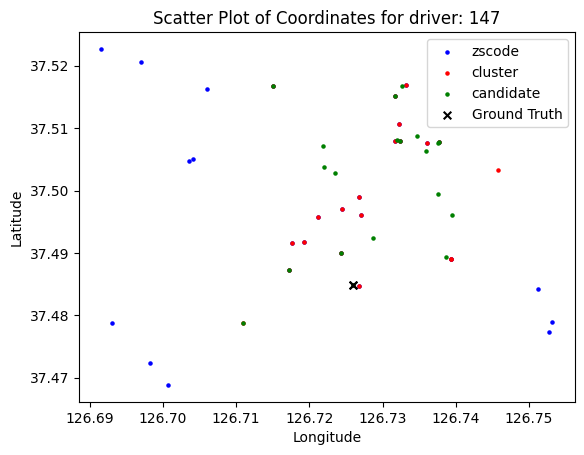

In [72]:
visulization(entire_rank, 147, test_dv, meta, 'Cluster')

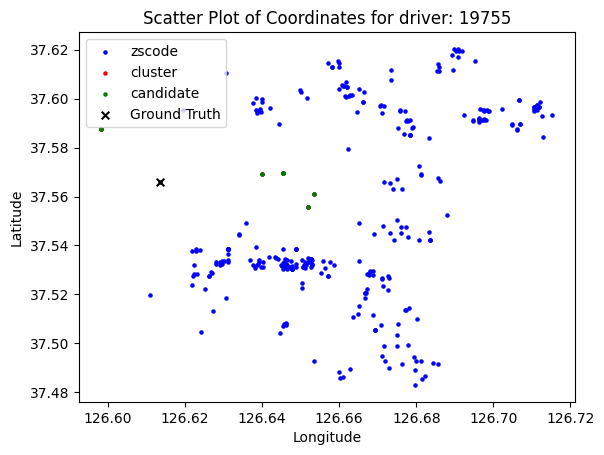

In [37]:
visulization(entire_rank, 19755, test_dv, meta, 'Cluster')

In [9]:
driver_num = len(test_dv['Driver'].unique())

In [347]:
rank1 = []
for i in tqdm(range(10000)):
    a, b, c = evaluation(entire_rank, i, test_dv, meta, 'zscode')
    rank1.append((b,c))

np.save('./rank1_20_10000.npy', np.array(rank1))

100%|██████████| 10000/10000 [35:47<00:00,  4.66it/s] 


In [14]:
zscodendcg = np.load('./ndcgs_cluster_10000.npy')

In [15]:
zscodendcg.mean(axis=0)

array([0.2201    , 0.29493856, 0.38136482, 0.44348165, 0.49064897])

In [7]:


array([[1.        , 0.63994539, 0.69931013, 0.7735922 , 0.83617336],
       [0.        , 0.3065736 , 0.52498103, 0.52498103, 0.52498103],
       [0.        , 0.3065736 , 0.52498103, 0.52498103, 0.52498103],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.49818926, 0.49818926, 0.49818926, 0.60677013]])

In [12]:
a, b, c = evaluation(entire_rank, 0, test_dv, meta, 'zscode')

In [13]:
a

,statnm,statid,chgerid,chgertype,addr,lat,lng,busiid,output,zscode,usetime,speed,Count,Cluster
0,인천적십자병원,553,01,4,인천광역시 연수구 원인재로 263,37.418560,126.689289,45,100,28185,24시간 이용가능,1,1,50
1,송도더샵퍼스트월드 주상복합 지하2층 4동 뒤 (급),2592,01,4,인천광역시 연수구 해돋이로 107,37.390360,126.647873,11,50,28185,24시간 이용가능,1,1,54
2,연수역 남부 공영주차장,684,01,4,인천광역시 연수구 청학동 466-1,37.418597,126.676707,45,100,28185,24시간 이용가능,1,1,50
3,인천송도 메가와티,4526,01,6,인천광역시 연수구 인천타워대로197번길 16,37.389004,126.635327,18,50,28185,24시간 이용가능,1,32,54
4,송도컨벤시아,163,01,6,인천광역시 연수구 센트럴로 123,37.388870,126.646265,45,50,28185,06:00~20:00,1,1,54
5,함박종합사회복지관,552,01,4,인천광역시 연수구 함박안로 217,37.425984,126.687375,45,100,28185,09:00~18:00,1,1,50
6,홈플러스 인천연수점,9132,01,4,인천광역시 연수구 청능대로 210,37.405000,126.680000,40,50,28185,24시간 이용가능,1,3,50
7,인천 코텍 급속충전소,3297,01,4,인천광역시 연수구 벤처로24번길 26,37.380245,126.636013,16,100,28185,24시간 이용가능,1,2,54
8,인천연수경찰서,13855,31,4,인천광역시 연수구 원인재로 138,37.410117,126.680289,45,300,28185,24시간 이용가능,1,2,50
9,동춘동 공영주차장,8364,01,6,인천광역시 연수구 앵고개로246번길 7-14,37.407745,126.671402,35,50,28185,24시간 이용가능,1,1,50


In [28]:
def precision(rank, K):
    pres_K = []
    for k in K:
        pres = []
        for j in rank:
            if (j[0] <= k) & (j[0] != 0):
                pres.append(1)
            else:
                pres.append(0)
        pres_K.append(np.sum(pres))
    return pres_K

In [29]:
pres = precision(rankzscode, [1, 5, 10, 15, 20])

[0.029643458367505503,
 0.11220162299823024,
 0.19323822678810376,
 0.2627767945784953,
 0.3241679975827686]

In [34]:
a, b, c = evaluation(entire_rank, 180000, test_dv, meta, 'zscode')

In [164]:
def get_ndcg(recommended_df, test_dv, driver_id, K):
    busiid = test_dv.loc[test_dv['Driver'] == driver_id]['busiid'].values[0]
    ex = (recommended_df['busiid'] == busiid).values
    
    ndcgs = []
    for j in K:
        if len(ex) >= j:
            dcg = 0
            for i in range(j):
                if ex[i] == True:
                    dcg += 1/np.log2(2 + i)

            idcg = 0
            sum_ex = ex.sum()
            if sum_ex >= j:
                for i in range(j):
                    idcg += 1/np.log2(2 + i)
            else:
                for i in range(sum_ex):
                    idcg += 1/np.log2(2 + i)

            if idcg == 0:
                ndcgs.append(0)
            else:
                ndcgs.append(dcg/idcg)
        else:
            ndcgs.append(ndcgs[-1])

    return ndcgs


In [103]:
ndcgs = []
for i in tqdm(range(10)):
    a, b, c = evaluation(entire_rank, i, test_dv, meta, 'Cluster')
    try:
        ndcg = get_ndcg(a, test_dv, i, [1, 5, 10, 15, 20])
        ndcgs.append(ndcg)
    except:
        print(i)
    


 10%|█         | 1/10 [00:00<00:01,  5.57it/s]

0
1


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


In [158]:
a, b, c = evaluation(entire_rank, 2, test_dv, meta, 'Cluster')
ndcg = get_ndcg(a, test_dv, 2, [1, 5, 10, 15, 20])

In [163]:
a

,statnm,statid,chgerid,chgertype,addr,lat,lng,busiid,output,zscode,usetime,speed,Count,Cluster
0,서울식물원 공영주차장,12265,01,4,서울특별시 강서구 양천로 291,37.571731,126.836157,64,50,11500,24시간 이용가능,1,10,92
1,도로교통공단 강서운전면허시험장 별관 제2주차장,1478,01,4,서울특별시 강서구 남부순환로 171,37.550146,126.819460,9,100,11500,09:00~18:00,1,2,92
2,강서 농산물도매시장 E-pit,6636,01,4,서울특별시 강서구 발산로 40,37.553355,126.819509,23,260,11500,24시간 이용가능,1,6,92
3,신신기업,1268,01,4,서울특별시 강서구 강서로 519-11,37.571642,126.841408,9,100,11500,24시간 이용가능(택시차고지 차량다수로 이용이 어려울 수 있음),1,4,92
4,영인운수,10671,01,4,서울특별시 강서구 남부순환로 224-58,37.545274,126.818236,52,120,11500,09:00~18:00,1,10,92
5,서울강서 정우상운,5673,01,4,서울특별시 강서구 남부순환로 216-1,37.546215,126.820240,18,100,11500,24시간 이용가능,1,4,92
6,마곡 보타닉비즈타워,13646,01,4,서울특별시 강서구 마곡중앙5로1길 20,37.568647,126.826746,4,100,11500,24시간 이용가능,1,2,92
7,도로교통공단 강서운전면허시험장 별관 제1주차장,1479,01,4,서울특별시 강서구 남부순환로 171,37.549159,126.820214,9,100,11500,09:00~18:00,1,2,92
8,마곡 보타닉비즈타워,874,01,4,서울특별시 강서구 마곡중앙5로1길 20,37.568647,126.826746,4,100,11500,24시간 이용가능,1,1,92
9,호디 RD 센터,14073,03,2,서울특별시 강서구 마곡중앙2로 39,37.557886,126.831207,47,50,11500,24시간 이용가능,1,2,92


In [159]:
ndcg

[0.0, 0.0, 0.0, 0.10253313861822189, 0.38053575523655686]

In [157]:
a

,statnm,statid,chgerid,chgertype,addr,lat,lng,busiid,output,zscode,usetime,speed,Count,Cluster
0,중랑경찰서,1395,01,4,서울특별시 중랑구 신내역로3길 40-10,37.618561,127.103961,9,100,11260,09:00~18:00,1,2,211
1,KD중랑대원교통,10657,01,4,서울특별시 중랑구 신내역로 25,37.613312,127.104234,52,120,11260,24시간 이용가능,1,46,211
2,KD중랑대원여객,10658,01,4,서울특별시 중랑구 신내역로 25,37.613312,127.104234,52,120,11260,24시간 이용가능,1,8,211
3,망우제2 거주자주차장,11189,01,4,서울특별시 중랑구 망우로71길 53,37.603155,127.101864,59,50,11260,"주중 08:00~19:00, 주말 09:00~18:00",1,1,211
4,중랑구청,11202,01,4,서울특별시 중랑구 봉화산로 179,37.606906,127.093274,59,100,11260,"주중 08:00~19:00, 주말 09:00~18:00",1,2,211
5,서울시 중랑구 중랑경찰서,9714,11,4,서울특별시 중랑구 신내역로3길 40-10,37.618254,127.104468,51,100,11260,24시간 이용가능,1,2,211
6,서울의료원,161,01,6,서울특별시 중랑구 신내로 156,37.612846,127.099341,45,50,11260,24시간 이용가능,1,1,211
7,일흥교통_2,3568,01,4,서울특별시 중랑구 양원역로 2,37.600827,127.108617,18,100,11260,운영시간 이용가능,1,2,211
8,서울중랑 새한택시2,4403,01,4,서울특별시 중랑구 용마산로 571,37.601929,127.100107,18,200,11260,평일 09:00~18:00,1,4,211
9,롯데하이마트 상봉점,6647,01,6,서울특별시 중랑구 망우로 399,37.599255,127.096547,24,50,11260,24시간 이용가능,1,1,211


In [146]:
ndcgs

[0.0,
 0.6934264036172708,
 0.6934264036172708,
 0.6934264036172708,
 0.6934264036172708]

In [142]:
ndcg = get_ndcg(a, test_dv, 1, [1, 5, 10, 15, 20])


In [143]:
ndcg

[0.0,
 0.6934264036172708,
 0.6934264036172708,
 0.6934264036172708,
 0.6934264036172708]

In [104]:
ndcgs = np.array(ndcgs)

In [105]:
ndcgs

array([[0.        , 0.        , 0.        , 0.10253314, 0.38053576],
       [0.        , 0.49818926, 0.64623021, 0.64623021, 0.64623021],
       [0.        , 0.        , 0.        , 0.12681702, 0.34793678],
       [0.        , 0.        , 0.        , 0.2030906 , 0.38892273],
       [0.        , 0.23719771, 0.42177341, 0.42177341, 0.42177341],
       [1.        , 0.46927873, 0.6105457 , 0.74144769, 0.74144769],
       [1.        , 1.        , 0.81046163, 0.94953752, 0.94953752],
       [0.        , 0.63092975, 0.63092975, 0.63092975, 0.63092975]])

In [96]:
ndcgs[0]

array([0.        , 0.49818926, 0.49818926])

In [51]:
ex = (a['busiid'] == 60).values

In [66]:
idcg = 0
sex = ex.sum()
if sex > 15:
    for i in range(len(ex[:15])):
        idcg += 1/np.log2(2 + i)
else:
    for i in range(sex):
        idcg += 1/np.log2(2 + i)